In [ ]:
%%shell
rm -rf fdd
git clone https://github.com/Davidvandijcke/fdd.git
pip install geopandas folium matplotlib mapclassify contextily rasterio scikit-image geocube pandas==2.0.0



In [1]:
from FDD import FDD

In [2]:
# load libraries
import geopandas as gpd
import numpy as np
import os
import urllib
import zipfile
import re
#from geocube.api.core import make_geocube
import rasterio as rio
from rasterio.mask import mask
from rasterio.transform import from_origin
from skimage import data, img_as_float, io
from skimage.segmentation import chan_vese
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geocube.api.core import make_geocube

In [3]:
# # set path
bsdir = "s3://ipsos-dvd/fdd/data/out/ukr/" # set to desired directory


## Now let's segment the map of mobile device activity

In [4]:
grid = gpd.read_file(bsdir + "grid_daily/" + "2022-11-11.geojson")


In [5]:
#grid.explore(column='count_ratio', cmap='Reds', legend=True,  vmax = 0.5)

In [6]:
X1 = np.array(grid.geometry.centroid.x)
X2 = np.array(grid.geometry.centroid.y)
X = np.stack([X1, X2], axis = 1)

Y = np.array(grid['count_ratio'])

# winsorize
qtile = np.quantile(Y, 0.9)
Y[Y > qtile] = qtile # 0.5

In [8]:
# as image
X1_width = 10000 #np.diff(np.unique(X1)).min()
X2_width = 10000 # np.diff(np.unique(X2)).min()
X = np.stack([X2, X1]).T

In [23]:
model.grid_y.flatten().shape

(425,)

In [21]:
# segment
#--------
# parameters
S=16
N = Y.shape[0]
#--------
resolution = 1/int(np.sqrt(N))
model = FDD(Y, X, level = S, lmbda = 5, nu = 0.01, iter = 5000, tol = 5e-5, pick_nu = "MS", CI=False, rectangle=True, resolution=resolution,
            scripted=False)


In [22]:
results = model.run()

/home/ubuntu/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/ubuntu/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


In [13]:
results['it']

400

In [14]:
u = results['u']
J_grid = results['J']

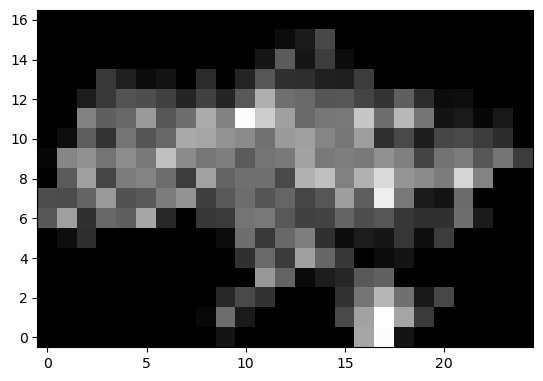

In [17]:
plt.imshow(model.grid_y, origin ="lower", cmap = "gray")
plt.show()

In [285]:
X_coord = model.grid_x * np.max(model.X_raw) +  np.min(model.X_raw, axis=0)

In [300]:
np.mean(X_coord, axis = 0)

array([7913715.07859395, 2321909.79218982])

In [305]:
np.mean(grid.geometry.centroid.y)

5441495.883534709

In [298]:
model.grid_x_og

array([[list([array([0., 0.]), array([0.        , 0.00759079]), array([0.00759079, 0.        ]), array([0.00759079, 0.00759079])]),
        list([array([0.00759079, 0.01518158]), array([0.        , 0.01518158])]),
        list([array([0.        , 0.02277237]), array([0.00759079, 0.02277237])]),
        ...,
        list([array([0.00759079, 0.97921201]), array([0.        , 0.97921201])]),
        list([array([0.       , 0.9868028]), array([0.00759079, 0.9868028 ])]),
        list([array([0.00759079, 0.99439359]), array([0.00759079, 1.        ]), array([0.        , 0.99439359]), array([0., 1.])])],
       [list([array([0.01518158, 0.00759079]), array([0.01518158, 0.        ])]),
        list([array([0.01518158, 0.01518158])]),
        list([array([0.01518158, 0.02277237])]), ...,
        list([array([0.01518158, 0.97921201])]),
        list([array([0.01518158, 0.9868028 ])]),
        list([array([0.01518158, 1.        ]), array([0.01518158, 0.99439359])])],
       [list([array([0.0227723

In [286]:
X_coord = X_coord.reshape(-1, X_coord.shape[-1])
Y_coord = u.flatten()

In [287]:
u_gdf = gpd.GeoDataFrame(np.stack([Y_coord, J_grid.flatten()]).T, geometry=gpd.points_from_xy(X_coord[:,0], X_coord[:,1]), crs = grid.crs, columns=['u', 'J_grid'])


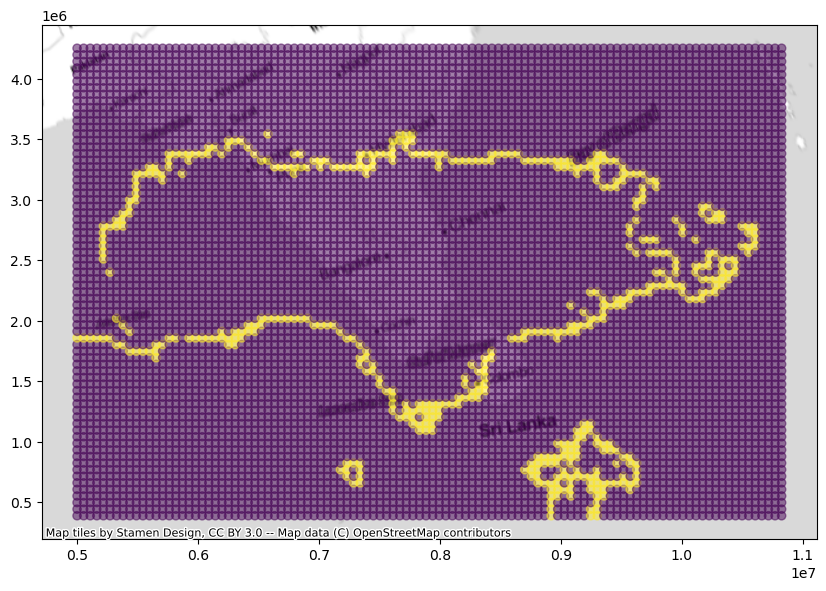

In [288]:
import contextily as ctx
fig, ax =  plt.subplots(figsize=(10,10))
u_gdf.plot(column="J_grid", ax=ax, alpha=0.5)
ctx.add_basemap(ax, crs=u_gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

In [279]:
grid

,day,index_right,week,count,devices,count_jan,devices_jan,count_ratio,devices_ratio,geometry
0,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((384522.909 5006526.396, 394522.909 5..."
1,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((394522.909 4996526.396, 394522.909 5..."
2,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((384522.909 5016526.396, 394522.909 5..."
3,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((394522.909 5016526.396, 404522.909 5..."
4,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((404522.909 5016526.396, 414522.909 5..."
...,...,...,...,...,...,...,...,...,...,...
11832,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((1684522.909 5016526.396, 1694522.909..."
11833,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((1694522.909 5016526.396, 1704522.909..."
11834,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((1709294.526 5006526.396, 1704522.909..."
11835,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"POLYGON ((1694522.909 4996526.396, 1694522.909..."


In [280]:
u_gdf

,u,J_grid,geometry
0,0.018627,0.0,POINT (5001526.396 389522.909)
1,0.018627,0.0,POINT (5055959.829 389522.909)
2,0.018627,0.0,POINT (5110393.263 389522.909)
3,0.018626,0.0,POINT (5164826.696 389522.909)
4,0.018626,0.0,POINT (5219260.129 389522.909)
...,...,...,...
7771,0.019441,0.0,POINT (10608170.028 4254296.675)
7772,0.019439,0.0,POINT (10662603.461 4254296.675)
7773,0.019436,0.0,POINT (10717036.895 4254296.675)
7774,0.019435,0.0,POINT (10771470.328 4254296.675)


In [271]:
# merge in ISW shapefile
isw = gpd.read_file("s3://ipsos-dvd/fdd/data/in/ukr/Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO11NOV2022.shp.zip")
isw = isw.to_crs(grid.crs)

In [274]:
isw

,FID_Crimea,Shape_Leng,ADM1_EN,ADM1_UA,ADM1_RU,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1UA,...,Shape__Len,GlobalID,CreationDa,Creator,EditDate,Editor,GlobalID_2,Shape__A_1,Shape__L_1,geometry
0,1,2.836671,Sevastopol,Севастопольська,Севастополь,UA85,Sevastopol,NaN,NaN,NaN,...,3.290901e+06,ee84decf-8479-4705-843a-6c5d269af18c,2022-02-24,gbarros_understandingwar,2022-03-05,rahma.bayrakdar_understandingwar,{27527d80-dd51-4d38-bc0a-8123f836f9d8},2.276265e+11,5.464168e+06,"POLYGON ((1167163.604 5213038.784, 1167524.686..."
1,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,ce2af81e-75c4-4b63-a920-a1c67ce65ecd,2022-03-02,rahma.bayrakdar_understandingwar,2022-03-02,rahma.bayrakdar_understandingwar,{4c249f7d-b27a-45b5-959c-34cff064aec8},1.664730e+07,2.092005e+04,"POLYGON ((1124722.892 5199541.950, 1124726.722..."
2,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,da88dbd5-cc75-494f-82f5-65a903eeaf5d,2022-03-02,rahma.bayrakdar_understandingwar,2022-03-02,rahma.bayrakdar_understandingwar,{3b6713f6-942e-480f-8662-44fa6cf6ffae},4.136671e+07,6.636226e+04,"MULTIPOLYGON (((1115242.664 5179940.688, 11152..."


In [275]:
u_gdf

,u,J_grid,geometry
0,0.018627,0.0,POINT (5001526.396 389522.909)
1,0.018627,0.0,POINT (5055959.829 389522.909)
2,0.018627,0.0,POINT (5110393.263 389522.909)
3,0.018626,0.0,POINT (5164826.696 389522.909)
4,0.018626,0.0,POINT (5219260.129 389522.909)
...,...,...,...
7771,0.019441,0.0,POINT (10608170.028 4254296.675)
7772,0.019439,0.0,POINT (10662603.461 4254296.675)
7773,0.019436,0.0,POINT (10717036.895 4254296.675)
7774,0.019435,0.0,POINT (10771470.328 4254296.675)


<Axes: >

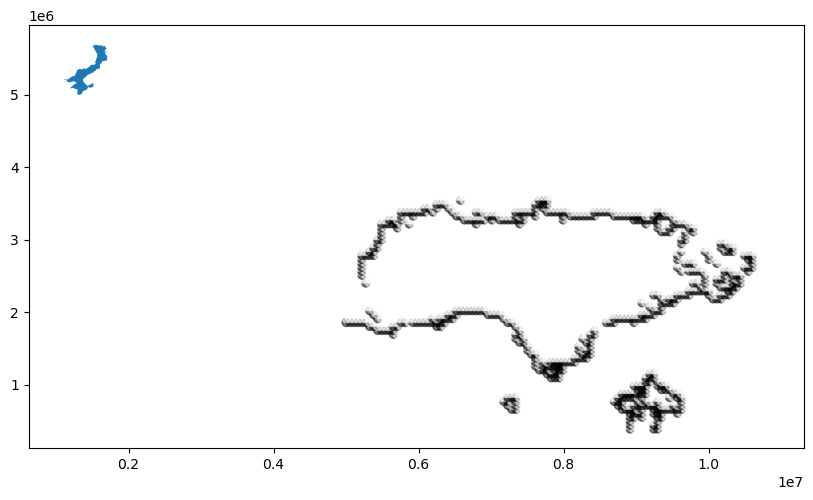

In [273]:
fig, ax = plt.subplots(figsize=(10, 6))
u_gdf.plot(ax=ax, cmap = "binary", column="J_grid", alpha=0.5)
isw.plot(ax=ax)

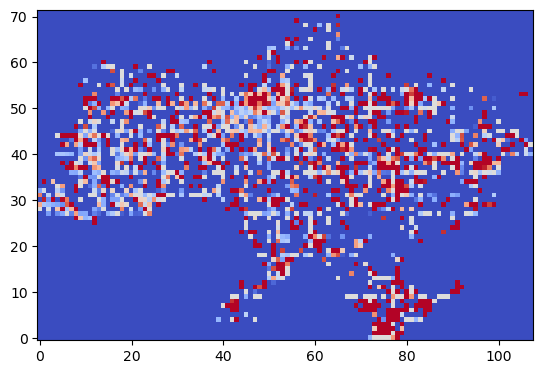

In [265]:
plt.imshow(model.grid_y, origin="lower", cmap="coolwarm")

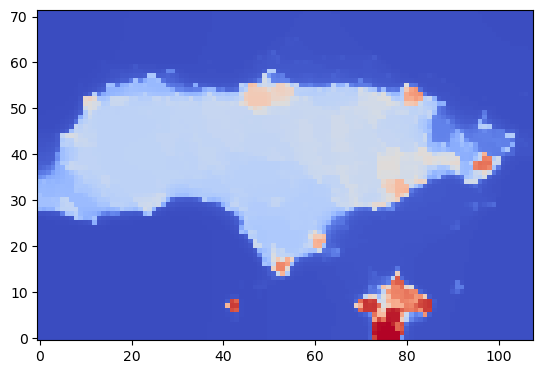

In [266]:
plt.imshow(u, origin="lower", cmap="coolwarm")

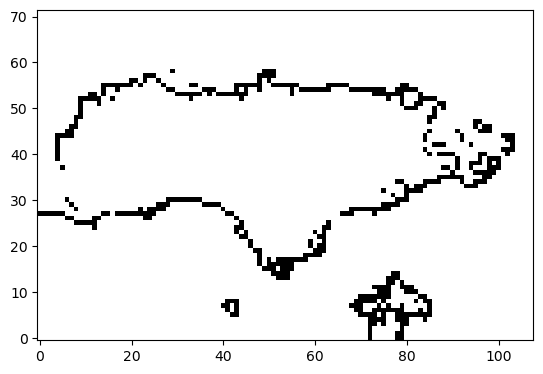

In [267]:
plt.imshow(J_grid, origin="lower", cmap="binary")